In [1]:
import get_news
import pandas as pd
from pprint import pprint

In [2]:
new_path = './news_20191220.pkl'
#df = get_news.incrental_load('./news_20191220.pkl')

# Incrementally loading data
df = pd.read_pickle(new_path)

In [95]:
df.head()

,timestamp,headline,link,content
0,"Last updated December 20, 2019 19:38:56 AEDT",‘ABSOLUTELY PETRIFIED’: Drug dealer sobs as he...,https://www.news.com.au/national/courts-law/te...,A terrified drug dealer has sobbed and called ...
1,"Last updated December 20, 2019 19:38:57 AEDT",'Do you even care?' Firey blasts ScoMo,https://www.news.com.au/technology/environment...,A fire station officer has posted an emotional...
2,"Last updated December 20, 2019 19:38:58 AEDT",Roads melting in extreme heat,https://www.news.com.au/technology/environment...,Roads in parts of South Australia are “bleedin...
3,"Last updated December 20, 2019 19:38:58 AEDT",‘Grossly immoral’: Christians lash Trump,https://www.news.com.au/finance/work/leaders/u...,A major Christian magazine has turned against ...
4,"Last updated December 20, 2019 19:38:58 AEDT",‘This is ridiculous’: Teen’s freakish act,https://www.news.com.au/sport/cricket/big-bash...,The Hobart Hurricanes looked like they were st...


## Stem/Tokenise

Tokenise is basically a function converts sentses into "tokens" or a list of words. In function below we did **stem** on top of the tokenised words, and removed **stop words** from the tokens

In [5]:
#%%
import nltk
import re
from nltk.tokenize import punkt
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer 
  
#sample = df.sample(1).content.iloc[0]
keep = re.compile('[a-zA-Z]')

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def stem_tokenise(corpus):    
    return [lemmatizer.lemmatize(ps.stem(w.lower())) for w in word_tokenize(corpus) if re.match(keep, w)]

# stem tokenise the stop words as well
stop_words = stem_tokenise(" ".join(list(set(stopwords.words('english')))))

In [111]:
import spacy

def cleansing(text):    
    # Remove Emails
    text = re.sub('\S*@\S*\s?', '', text) 

    # Remove new line characters
    text = re.sub('\s+', ' ', text)

    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    
    return text

data = df.content.map(cleansing).map(lambda x: " ". join(stem_tokenise(x)))


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
#data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:2])



In [121]:
print(data.to_list()[300])

one night a woman heard blind rattl in the room next door hour later her neighbour s bodi wa found in a pool of blood warn graphic how mani australian die by homicid each year and the horrifi way they are lose their live peter dupa arriv at the suprem court.sourc news limit warn graphic thi octob it final look like polic would be abl to have their day in court over the shock nurs home murder of kathleen down have charg one of australia s most deprav serial killer mr down had live at the brunswick lodg nurs home on quiet loyola ave for eight year becom known a the matriarch of the commun despit her age she wa still sprite a person who wa abl to get up and get about a she wa later describ geoff down son of kathleen down who wa stab three time in the neck the onli suspect is peter dupa and the famili is call for an inquest.sourc news limit a is custom a member of staff check on mr down at on new year s eve and found her soundli sleep at anoth resid heard blind rattl and a door open no dou

## SKlearn DTM

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Below is an example of sklearn LDA, the problem is it is pretty slow and not as customisable compared to gensim.

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# use own tokeniser and stopwords (note: do the same processing for stop words)
#cv = CountVectorizer(stop_words=stop_words, tokenizer=stem_tokenise)

cv = CountVectorizer(analyzer='word',       
         min_df=10,                        # minimum reqd occurences of a word 
         stop_words='english',             # remove stop words
         lowercase=True,                   # convert all words to lowercase
         token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
         # max_features=50000,             # max number of uniq words
)


# get the dtm (coverting the matrix into dataframe)
data_cv = cv.fit_transform(data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df.index
#pprint(data_dtm)

# calculate the sparsity
data_dense = data_cv.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  10.002603858444786 %


In [132]:
import numpy as np
row = data_dtm.iloc[300]
#pprint(row.nlargest(10))
#pprint(data.iloc[300])

## SKlearn Latent Direchlet Allocation

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [143]:
# simple LDA
lda = LatentDirichletAllocation(n_components=10, max_iter = 10, learning_method = 'online', batch_size = 128, random_state=0)
lda_output = lda.fit_transform(data_cv)

In [144]:
print("log likelihood: ", lda.score(data_cv))
print("Perplexity: ", lda.perplexity(data_cv))
pprint(lda.get_params())

log likelihood:  -764181.6115431432
Perplexity:  861.1281883103927
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Perform a grid search

In [135]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [7, 9, 15, 25,30], 'learning_decay': [0.5, 0.7, 0.9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_cv)

#best model
best_model = model.best_estimator_

In [138]:
print("best model parameters: ", best_model.get_params())
result = pd.DataFrame(model.cv_results_)
result

best model parameters:  {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.9, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 7, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.232711,0.082278,0.052016,0.003688,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-157731.861614,-208436.321722,-148239.621542,-152784.165697,-177270.352445,-168892.464604,22111.001423,2
1,2.231115,0.090433,0.052815,0.003241,0.5,9,"{'learning_decay': 0.5, 'n_components': 9}",-161823.805412,-209724.804839,-152100.719571,-156487.899217,-180599.026420,-172147.251092,21152.575775,6
2,2.292218,0.073240,0.070886,0.013456,0.5,15,"{'learning_decay': 0.5, 'n_components': 15}",-168216.191444,-216936.092724,-157907.023289,-162380.458096,-186635.908481,-178415.134807,21601.653917,8
3,3.107514,0.248635,0.088845,0.024717,0.5,25,"{'learning_decay': 0.5, 'n_components': 25}",-177952.514145,-228445.370608,-168409.045481,-172463.346767,-197687.326455,-188991.520691,22140.017144,12
4,3.843744,0.220209,0.116107,0.044077,0.5,30,"{'learning_decay': 0.5, 'n_components': 30}",-181479.939747,-229235.802568,-173653.471263,-177823.488796,-200514.419724,-192541.424420,20522.060757,13
5,2.279140,0.115107,0.052112,0.004078,0.7,7,"{'learning_decay': 0.7, 'n_components': 7}",-158183.653384,-208198.035396,-148273.084310,-153385.097701,-177982.816111,-169204.537381,21942.613101,3
6,2.420311,0.105493,0.059904,0.005130,0.7,9,"{'learning_decay': 0.7, 'n_components': 9}",-161549.395692,-210925.923330,-151221.416166,-155431.994015,-180496.027816,-171924.951404,21921.885563,5
7,2.532928,0.057633,0.067494,0.003982,0.7,15,"{'learning_decay': 0.7, 'n_components': 15}",-168490.027035,-216740.277745,-155802.199725,-163968.625905,-187031.557844,-178406.537651,21732.984951,7
8,3.231308,0.163236,0.095247,0.025086,0.7,25,"{'learning_decay': 0.7, 'n_components': 25}",-179088.184383,-225666.918019,-168148.693655,-174002.766333,-196960.637403,-188773.439959,20811.131927,11
9,4.403746,0.492396,0.130550,0.044299,0.7,30,"{'learning_decay': 0.7, 'n_components': 30}",-180479.902901,-233589.636437,-171869.785200,-176462.580568,-201172.788295,-192714.938680,22762.389177,14


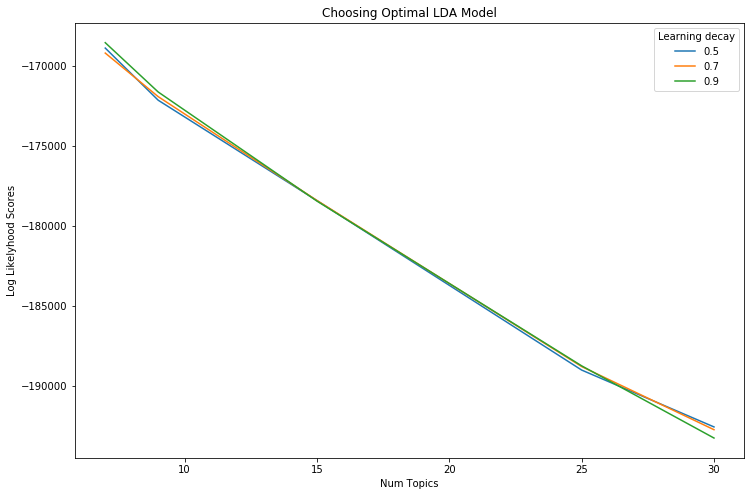

In [139]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
for x in result.param_learning_decay.unique():
    plt.plot(result[result.param_learning_decay==x].param_n_components, result[result.param_learning_decay==x].mean_test_score, label=x)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Finding Dominate Topic

In [142]:
# Create Document - Topic Matrix
lda_output = best_model.transform(data_cv)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc0,0,0.02,0.1,0,0.74,0.03,0.1,4
Doc1,0,0,0,0,0,0.04,0.96,6
Doc2,0,0.05,0,0,0,0,0.95,6
Doc3,0,0,0,0,0.86,0.13,0,4
Doc4,0,0.87,0,0.02,0.04,0,0.06,1
Doc5,0.03,0.73,0,0,0.17,0.06,0,1
Doc6,0,0,0,0,0,1,0,5
Doc7,0,0.53,0,0,0.47,0,0,1
Doc8,0,0,0.08,0,0.72,0,0.2,4
Doc9,0,0.1,0,0,0.24,0.66,0,5


## Gensim

https://www.machinelearningplus.com/nlp/gensim-tutorial/

### Dictionary ###
**Dictionary** object convert text/sentences to a [list of word] with id's. (https://radimrehurek.com/gensim/corpora/dictionary.html)

The object can be incrementally added by calling method *add_documents()*

Dictionary can be stored into disk and loaded later

In [16]:
import gensim
from gensim import corpora


# create a gensim dictory from a pandas series object (created by a column from a dataframe)
def create_dictionary(df, column_name, save_to_file=None):
    dict = corpora.Dictionary(df[column_name].map(stem_tokenise))
    if save_to_file:
        dict.save(save_to_file)
    return dict

dict = create_dictionary(df, "content", 'my_dict.dict')
#dict = corpora.Dictionary.load('my_dict.dict')
#dict.token2id 

## Bag of Word / TF IDF

In [17]:
# for each of the document generate bag of the words. Thr reprsentation is (id, count) tuple (only occurring words)
def create_bow(data_frame, column_name, dict, save_to_file=None):
    my_corpus = [dict.doc2bow(doc, allow_update=True) for doc in data_frame[column_name].map(stem_tokenise)]
    if save_to_file:
        corpora.MmCorpus.serialize(save_to_file, my_corpus)
    return my_corpus

#my_corpus = create_bow(df, "content", dict, 'bow_corpus.mm')
my_corpus = corpora.MmCorpus('bow_corpus.mm')

# Show the Word Weights in Corpus
for doc in my_corpus:
    print([[dict[id], freq] for id, freq in doc])
    break

[['absolut', 1.0], ['accept', 1.0], ['acknowledg', 1.0], ['across', 1.0], ['act', 1.0], ['ad', 1.0], ['addict', 1.0], ['advertis', 2.0], ['aedt', 1.0], ['afternoon', 1.0], ['age', 1.0], ['allegedli', 3.0], ['almost', 1.0], ['also', 2.0], ['anoth', 1.0], ['appear', 1.0], ['area', 1.0], ['arrest', 2.0], ['ask', 1.0], ['australia', 10.0], ['away', 1.0], ['back', 1.0], ['background', 1.0], ['bail', 1.0], ['becam', 1.0], ['began', 1.0], ['behind', 1.0], ['believ', 1.0], ['black', 1.0], ['boob', 2.0], ['bought', 1.0], ['bra', 4.0], ['bra.sourc', 1.0], ['brought', 1.0], ['burwood', 1.0], ['buyer', 1.0], ['call', 3.0], ['came', 3.0], ['candace.sutton', 1.0], ['cap', 6.0], ['capsul', 6.0], ['carri', 3.0], ['cell', 1.0], ['centr', 1.0], ['chanc', 1.0], ['chaotic', 1.0], ['childhood', 1.0], ['chill', 1.0], ['choic', 1.0], ['circuz', 1.0], ['clear', 1.0], ['co-offend', 1.0], ['collect', 1.0], ['comfort', 1.0], ['commerci', 1.0], ['community-bas', 1.0], ['condom', 2.0], ['contain', 1.0], ['content'

In [21]:
from gensim import models
import numpy as np
import wordcloud as wc

# Create the TF-IDF model
tfidf = models.TfidfModel(my_corpus, smartirs='ntc')

# Show the TF-IDF weights
for doc in tfidf[my_corpus]:
    print([[dict[id], np.around(freq, decimals=2)] for id, freq in doc])    
    break


# get a word cloud going
wc = wc.WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud
weights = tfidf[my_corpus[0]]

weights = [[dict[id], np.around(freq, decimals=2)] for id, freq in weights]

pprint(weights)


[['absolut', 0.01], ['accept', 0.01], ['acknowledg', 0.02], ['across', 0.0], ['act', 0.01], ['ad', 0.0], ['addict', 0.02], ['advertis', 0.0], ['aedt', 0.0], ['afternoon', 0.02], ['age', 0.01], ['allegedli', 0.05], ['almost', 0.01], ['also', 0.0], ['anoth', 0.01], ['appear', 0.0], ['area', 0.01], ['arrest', 0.03], ['ask', 0.01], ['australia', 0.05], ['away', 0.01], ['back', 0.0], ['background', 0.02], ['bail', 0.02], ['becam', 0.01], ['began', 0.01], ['behind', 0.01], ['believ', 0.01], ['black', 0.01], ['boob', 0.03], ['bought', 0.01], ['bra', 0.08], ['bra.sourc', 0.02], ['brought', 0.01], ['burwood', 0.02], ['buyer', 0.01], ['call', 0.02], ['came', 0.02], ['candace.sutton', 0.02], ['cap', 0.09], ['capsul', 0.15], ['carri', 0.03], ['cell', 0.02], ['centr', 0.01], ['chanc', 0.01], ['chaotic', 0.02], ['childhood', 0.02], ['chill', 0.02], ['choic', 0.0], ['circuz', 0.02], ['clear', 0.01], ['co-offend', 0.02], ['collect', 0.0], ['comfort', 0.01], ['commerci', 0.02], ['community-bas', 0.02],

## Download W2V trained model

In [65]:
import gensim.downloader as api

# Get information about the model or dataset
api.info('glove-wiki-gigaword-50')
# {'base_dataset': 'Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)',
#  'checksum': 'c289bc5d7f2f02c6dc9f2f9b67641813',
#  'description': 'Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/).',
#  'file_name': 'glove-wiki-gigaword-50.gz',
#  'file_size': 69182535,
#  'license': 'http://opendatacommons.org/licenses/pddl/',
#  (... truncated...)

# Download
w2v_model = api.load("glove-wiki-gigaword-50")
w2v_model.most_similar('blue')
# [('red', 0.8901656866073608),
#  ('black', 0.8648407459259033),
#  ('pink', 0.8452916741371155),
#  ('green', 0.8346816301345825),
#  ... ]

[==================================================] 100.0% 66.0/66.0MB downloaded


[('red', 0.8901657462120056),
 ('black', 0.8648406863212585),
 ('pink', 0.845291793346405),
 ('green', 0.8346816301345825),
 ('yellow', 0.8320707082748413),
 ('purple', 0.8293111324310303),
 ('white', 0.8225342035293579),
 ('orange', 0.8114302158355713),
 ('bright', 0.799933910369873),
 ('colored', 0.7876655459403992)]

In [71]:
w2v_model.most_similar('son')

[('father', 0.9528983235359192),
 ('brother', 0.9449328184127808),
 ('cousin', 0.9256070256233215),
 ('uncle', 0.9207189679145813),
 ('nephew', 0.9195291996002197),
 ('grandson', 0.8999317288398743),
 ('grandfather', 0.8975841403007507),
 ('daughter', 0.8961816430091858),
 ('friend', 0.8672630786895752),
 ('elder', 0.8604500889778137)]